In [1]:
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import os

import sys
sys.path.append('axionCAMB_and_lin_PS/')
sys.path.append('cosmology/')
sys.path.append('axion_functions/')
sys.path.append('halo_model/')

from axionCAMB_and_lin_PS import axionCAMB_wrapper 
from axionCAMB_and_lin_PS import load_cosmology  
from axionCAMB_and_lin_PS import lin_power_spectrum 
from axionCAMB_and_lin_PS import PS_interpolate 

from halo_model import HMcode_params
from halo_model import PS_nonlin_cold
from halo_model import PS_nonlin_axion
from halo_model import baryons

from axion_functions import axion_params

In [2]:
### Baryons with no axions

start = time.time()

################################################################################
# Set-up experiment parameters
################################################################################

input_file_path = '/Users/cp2091/PhD/KR_ULADM/axionHMcode_Tagn/input_files/input_file.txt'
input_file_path_baryon = '/Users/cp2091/PhD/KR_ULADM/axionHMcode_Tagn/input_files/input_file_AXION_BARYON.txt'

try:
    f = open(input_file_path)
except IOError:
    print("Input file not accessible, pleas check the file path")
finally:
    f.close()
axionCAMB_exe_path = '/Users/cp2091/PhD/KR_ULADM/axionCAMB'
if os.path.exists(axionCAMB_exe_path+'/./camb') == False:
    print("executabel axionCAMB is not in the given directory, pleas check the path")

In [3]:
################################################################################    
# save cosmological parameter in a dictionary 
################################################################################

cosmos_AXION_BARYON = load_cosmology.load_cosmology_input(input_file_path_baryon) 
cosmos_LCDM = load_cosmology.load_LCDM_cosmology_input(input_file_path)

# Check here later for why LCDM not working

################################################################################
# Run axionCAMB on mixed and LCDM cosmology 
################################################################################

print("axionCAMB is running. Computes transfer function for a LCDM cosmology")
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                   cosmos_LCDM, output_root='paramfiles/cosmos_LCDM', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                axionCAMB_exe_path,
                                cosmos_LCDM, print_info = False)

print("axionCAMB is running. Computes transfer function for a same cosmology but now with baryons cosmology")
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_AXION_BARYON.txt', 
                                   cosmos_AXION_BARYON, output_root='paramfiles/cosmos_AXION_BARYON', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_AXION_BARYON.txt', 
                                axionCAMB_exe_path,
                                cosmos_AXION_BARYON, print_info = False)

axionCAMB is running. Computes transfer function for a LCDM cosmology


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


axionCAMB is running. Computes transfer function for a same cosmology but now with baryons cosmology


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


In [5]:
################################################################################
# Create linear power spectra from axionCAMB tranfer functions 
################################################################################
# lin PS on given k range

power_spec_dic_LCDM = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_LCDM_transfer_out.dat', cosmos_LCDM)
power_spec_dic_AXION_BARYON = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_AXION_BARYON_transfer_out.dat', cosmos_AXION_BARYON)

#interpolated lin PS for the correct computations of the variance

power_spec_interp_dic_LCDM = lin_power_spectrum.func_power_spec_interp_dic(power_spec_dic_LCDM, cosmos_LCDM)
power_spec_interp_dic_ax_AXION_BARYON = lin_power_spectrum.func_power_spec_interp_dic(power_spec_dic_AXION_BARYON, cosmos_AXION_BARYON)

##############################################
# Compute parameter related to axions and HMCode2020
################################################################################
print('-' * 50)
M_arr = np.logspace(cosmos_LCDM['M_min'], cosmos_LCDM['M_max'], 100)
print("Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.")

axion_param_AXION_BARYON = axion_params.func_axion_param_dic(M_arr, cosmos_AXION_BARYON, power_spec_interp_dic_ax_AXION_BARYON, eta_given=False)

print("Create dictionary with parameters of HMCode2020")

hmcode_params_LCDM = HMcode_params.HMCode_param_dic(cosmos_LCDM, power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'])
hmcode_params_AXION_BARYON = HMcode_params.HMCode_param_dic(cosmos_AXION_BARYON, power_spec_interp_dic_ax_AXION_BARYON['k'], power_spec_interp_dic_ax_AXION_BARYON['cold'])

print("computation time upto here: {:.0f} s".format(time.time() -start))



--------------------------------------------------
Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.
Create dictionary with parameters of HMCode2020
computation time upto here: 56 s


In [6]:
################################################################################
# Caluclate non-linear power spectrum in LCDM cosmology both DM only and with baryons
################################################################################

#print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model')
PS_LCDM_matter_nonlin = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=None)

#print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model - now including baryons via Tagn parameter')
T_agn_76 = 10**7.6
T_agn_78 = 10**7.8
T_agn_80 = 10**8
T_agn_83 = 10**8.3

PS_LCDM_matter_nonlin_baryons_76 = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=T_agn_76)
PS_LCDM_matter_nonlin_baryons_78 = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=T_agn_78)
PS_LCDM_matter_nonlin_baryons_80 = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=T_agn_80)
PS_LCDM_matter_nonlin_baryons_83 = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],  alpha = False, eta_given = False, one_halo_damping = True, two_halo_damping = False, Tagn=T_agn_83)

################################################################################
# Save both power spectra in files
################################################################################

#print("Save the non-linear power spectra in a file in the folowing order:")
#print("k [h/Mpc], non-lin total matter PS in LCDM [(Mpc/h)^3] and non-lin total matter PS with baryons in LCDM [(Mpc/h)^3]")
data_ax = np.column_stack([power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin[0], PS_LCDM_matter_nonlin_baryons[0]] )

#datafile_path = "output/nonlin_PS_CDMO_CDMBARYONS.txt" #change path if you want
#np.savetxt(datafile_path , data_ax)

These changes are working!
M[0] 10000000.0
M[99] 1e+18
Wk[0,:] before changes [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999998 0.99999998 0.99999998 0.99999998
 0.99999998 0.99999998 0.99999997 0.99999997 0.99999997 0.99999996
 0.99999996 0.99999995 0.99999995 0.99999994 0.99999994 0.99999993
 0.99999992 0.99999991 0.9999999  0.99999988 0.99999977 0.99999956
 0.99999915 0.99999834 0.99999676 0.99999368 0.9999877  0.99997604
 0.99995333 0.99990911 0.99982298 0.99965526 0.99932873 0.99869324
 0.99745744 0.99505785 0.99041201 0.98146877 0.96444248 0.93272338
 0.87608419 0.78299737 0

NameError: name 'PS_LCDM_matter_nonlin_baryons' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import hmcode

h =  0.674
Omega_c = 0.12/(h**2)
Omega_b =  0.02237/(h**2)
Omega_k = 0.0
ns = 0.9649
w0 = -1.
wa = 0.
sigma_8=0.8
m_nu = 0.
norm_sigma8 = True
As = 2.0989031673191437e-9

# AGN-feedback temperature [K]
T_AGNs = np.power(10, np.array([7.6, 7.8, 8.0, 8.3]))

# CAMB
kmax_CAMB = 88.

# Wavenumbers [h/Mpc]
kmin, kmax = 7.42280e-05, 1.32405e+03
nk = 88
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshifts
zs = [1., 0.5, 0.25, 0.]
zs = np.array(zs)

# Halo masses [Msun/h] (for halo model only)
Mmin, Mmax = 1e7, 1e18
nM = 100
M = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)


# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams(WantCls=False)
wb, wc = Omega_b*h**2, Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=zs, kmax=kmax_CAMB) # Setup the linear matter power spectrum
Omega_m = pars.omegam # Extract the matter density

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if norm_sigma8:
    results = camb.get_results(pars)
    print(results)
    sigma_8_init = results.get_sigma8_0()
    print('Running CAMB')
    print('Initial sigma_8:', sigma_8_init)
    print('Desired sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Run
results = camb.get_results(pars)
Pk_lin_interp = results.get_matter_power_interpolator(nonlinear=False).P
Pk_nonlin_interp = results.get_matter_power_interpolator(nonlinear=True).P
sigma_8 = results.get_sigma8_0()
print('Final sigma_8:', sigma_8)

# Arrays for CAMB non-linear spectrum
Pk_CAMB = np.zeros((len(zs), len(k)))
for iz, z in enumerate(zs):
    Pk_CAMB[iz, :] = Pk_nonlin_interp(z, k)

Rk_feedback = []

Pk_gravity, Pk_gravity_1halo, Pk_gravity_2halo = hmcode.power(k, zs, results, T_AGN=False, verbose=False,tweaks=False)

Pk_feedback_76, Pk_feedback_76_1halo, Pk_feedback_76_2halo = hmcode.power(k, zs, results, T_AGN=10**7.6, verbose=False,tweaks=False)
Pk_feedback_78, Pk_feedback_78_1halo, Pk_feedback_78_2halo = hmcode.power(k, zs, results, T_AGN=10**7.8, verbose=False,tweaks=False)
Pk_feedback_80, Pk_feedback_80_1halo, Pk_feedback_80_2halo = hmcode.power(k, zs, results, T_AGN=10**8.0, verbose=False,tweaks=False)

'''plt.plot(k,Pk_gravity[3],label='Pk gravity',color='green')
plt.plot(k,Pk_feedback_76[3],label='Pk feedback, Tagn=7.6',c
olor='red')
plt.plot(k,Pk_feedback_78[3],label='Pk feedback, Tagn=7.8',color='blue')
plt.plot(k,Pk_feedback_80[3],label='Pk feedback, Tagn=8.0',color='orange')
'''

class: <CAMBdata>
 Params: <CAMBparams>
   WantCls = False
   WantTransfer = True
   WantScalars = True
   WantTensors = False
   WantVectors = False
   WantDerivedParameters = True
   Want_cl_2D_array = True
   Want_CMB = True
   Want_CMB_lensing = True
   DoLensing = True
   NonLinear = NonLinear_none
   Transfer: <TransferParams>
     high_precision = True
     accurate_massive_neutrinos = False
     kmax = 88.0
     k_per_logint = 0
     PK_num_redshifts = 4
     PK_redshifts = [1.0, 0.5, 0.25, 0.0]
   want_zstar = False
   want_zdrag = False
   min_l = 2
   max_l = 2500
   max_l_tensor = 600
   max_eta_k = 5000.0
   max_eta_k_tensor = 1200.0
   ombh2 = 0.02237
   omch2 = 0.12
   omk = 0.0
   omnuh2 = 0.0
   H0 = 67.4
   TCMB = 2.7255
   YHe = 0.2458554819755239
   num_nu_massless = 3.044
   num_nu_massive = 0
   nu_mass_eigenstates = 0
   share_delta_neff = False
   nu_mass_degeneracies = []
   nu_mass_fractions = []
   nu_mass_numbers = []
   InitPower: <InitialPowerLaw>
     ten

"plt.plot(k,Pk_gravity[3],label='Pk gravity',color='green')\nplt.plot(k,Pk_feedback_76[3],label='Pk feedback, Tagn=7.6',c\nolor='red')\nplt.plot(k,Pk_feedback_78[3],label='Pk feedback, Tagn=7.8',color='blue')\nplt.plot(k,Pk_feedback_80[3],label='Pk feedback, Tagn=8.0',color='orange')\n"

[7.42280e-05 1.22381e-04 2.01773e-04 3.32667e-04 5.48475e-04 9.04282e-04
 1.49091e-03 2.45809e-03 4.05271e-03 4.59233e-03 5.20379e-03 5.89666e-03
 6.68179e-03 7.57146e-03 8.57959e-03 9.72195e-03 1.10164e-02 1.24832e-02
 1.41454e-02 1.60288e-02 1.81630e-02 2.05814e-02 2.33218e-02 2.64270e-02
 2.99457e-02 3.39330e-02 3.84511e-02 4.35708e-02 4.93722e-02 5.59460e-02
 6.33951e-02 7.08179e-02 7.82407e-02 8.56635e-02 9.30863e-02 1.00509e-01
 1.07932e-01 1.15355e-01 1.22778e-01 1.30200e-01 1.37623e-01 1.45046e-01
 1.52469e-01 1.59892e-01 1.67314e-01 1.74737e-01 1.82160e-01 1.89583e-01
 1.97006e-01 2.04428e-01 2.11851e-01 2.19274e-01 2.32559e-01 2.46650e-01
 2.61594e-01 2.77443e-01 2.94253e-01 3.12081e-01 3.30989e-01 3.51043e-01
 3.72313e-01 3.94870e-01 4.18795e-01 4.44169e-01 6.19887e-01 8.65122e-01
 1.20738e+00 1.68503e+00 2.35165e+00 3.28199e+00 4.58038e+00 6.39244e+00
 8.92136e+00 1.24508e+01 1.73764e+01 2.42508e+01 3.38447e+01 4.72341e+01
 6.59205e+01 9.19994e+01 1.28396e+02 1.79190e+02 2.

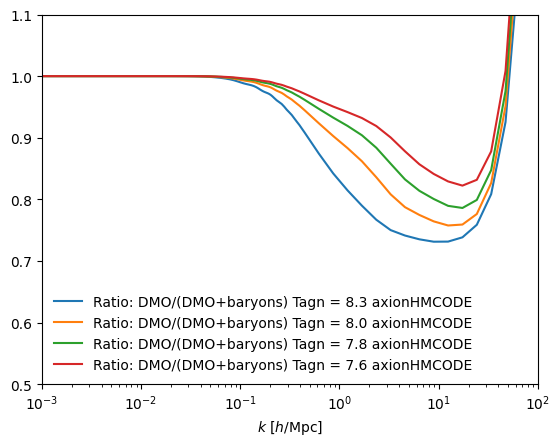

In [8]:

plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons_83[0]/PS_LCDM_matter_nonlin[0], label='Ratio: DMO/(DMO+baryons) Tagn = 8.3 axionHMCODE')
plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons_80[0]/PS_LCDM_matter_nonlin[0], label='Ratio: DMO/(DMO+baryons) Tagn = 8.0 axionHMCODE')
plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons_78[0]/PS_LCDM_matter_nonlin[0], label='Ratio: DMO/(DMO+baryons) Tagn = 7.8 axionHMCODE')
plt.plot(power_spec_dic_LCDM['k'], PS_LCDM_matter_nonlin_baryons_76[0]/PS_LCDM_matter_nonlin[0], label='Ratio: DMO/(DMO+baryons) Tagn = 7.6 axionHMCODE')

print(power_spec_dic_LCDM['k'])
#plt.plot(k,Pk_feedback_80[3]/Pk_gravity[3],label='Ratio: DMO/(DMO+baryons) HMCODE2020',color='green')

plt.xscale('log')
plt.legend(frameon=False)
plt.xlim([10**(-3),100])
plt.ylim(0.5,1.1)
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.savefig('axionsLCDM_Tagn.pdf')
plt.show()